In [1]:
import json
import influxdb
import pandas as pd
from odapi.formats import InfluxDB
from odapi.toolbox.psychro import Constants, Mix

In [2]:
with open("../../../../secrets/lht65.json") as fh:
    client = influxdb.InfluxDBClient(**json.load(fh))

In [3]:
q = client.query('SELECT "value" FROM /device_frmpayload_data_node_.*/ GROUP BY "device_name", "location"')

In [4]:
df = InfluxDB.to_frame(q.raw)

In [5]:
df.head()

,time,value,serie_name,device_name,location
0,2020-08-15 09:22:02.469000+00:00,61.5,device_frmpayload_data_node_humidity,node-T011,outdoor
1,2020-08-15 09:39:46.499000+00:00,64.6,device_frmpayload_data_node_humidity,node-T011,outdoor
2,2020-08-15 09:59:45.590000+00:00,66.2,device_frmpayload_data_node_humidity,node-T011,outdoor
3,2020-08-15 10:19:46.211000+00:00,64.8,device_frmpayload_data_node_humidity,node-T011,outdoor
4,2020-08-15 10:39:46.179000+00:00,64.3,device_frmpayload_data_node_humidity,node-T011,outdoor


In [6]:
df["time"] = df["time"].dt.round("20T")

In [7]:
df["serie_name"] = df["serie_name"].apply(lambda x: x.split("_")[-1])
df["location"] = df["location"].replace({'badroom-children': 'bathroom-children'})

In [8]:
dc = df.pivot_table(index="time", columns=["serie_name", "location"], values="value")

In [15]:
dc = dc[dc["temperature"]<300]

In [16]:
dc = dc.interpolate()

In [17]:
dc.head()

serie_name                         humidity                  \
location                  bathroom-children bathroom-parent   
time                                                          
2020-08-15 09:20:00+00:00              80.7            58.5   
2020-08-15 09:40:00+00:00              80.2            57.6   
2020-08-15 10:00:00+00:00              75.2            57.8   
2020-08-15 10:20:00+00:00              63.2            55.4   
2020-08-15 10:40:00+00:00              59.4            68.4   

serie_name                                                                \
location                  bedroom-child-left kitchen living-room outdoor   
time                                                                       
2020-08-15 09:20:00+00:00              58.90    59.4        59.8    61.5   
2020-08-15 09:40:00+00:00              60.20    59.6        59.4    64.6   
2020-08-15 10:00:00+00:00              60.00    55.3        59.0    66.2   
2020-08-15 10:20:00+00:00              57.95    53.5        55.8    64.8   
2020-08-15 10:40:00+00:00              55.90    52.3        55.3    64.3   

serie_name                      temperature                  \
location                  bathroom-children bathroom-parent   
time                                                          
2020-08-15 09:20:00+00:00             26.77           26.16   
2020-08-15 09:40:00+00:00             27.33           26.14   
2020-08-15 10:00:00+00:00             27.64           26.72   
2020-08-15 10:20:00+00:00             27.63           26.97   
2020-08-15 10:40:00+00:00             27.57           27.21   

serie_name                                                                
location                  bedroom-child-left kitchen living-room outdoor  
time                                                                      
2020-08-15 09:20:00+00:00              26.28   26.37       25.96   25.81  
2020-08-15 09:40:00+00:00              26.29   26.50       26.11   24.90  
2020-08-15 10:00:00+00:00              26.45   27.37       26.26   24.43  
2020-08-15 10:20:00+00:00              26.53   27.83       26.41   24.37  
2020-08-15 10:40:00+00:00              26.61   27.97       26.49   24.54

In [24]:
T = dc["temperature"]
RH = dc["humidity"]

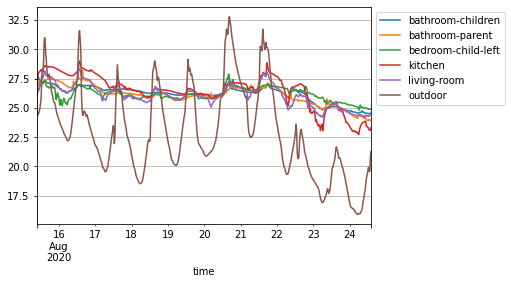

In [25]:
axe = T.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

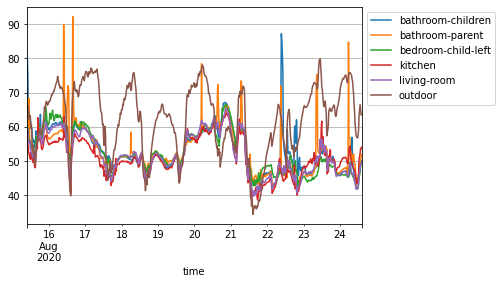

In [26]:
axe = RH.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

<AxesSubplot:title={'center':'Water Psychrometric Chart: $p_0 = 101.325$ $[\\mathrm{kPa}]$'}, xlabel='Temperature, $T$ $[\\mathrm{K}]$', ylabel='Partial Pressure, $p_w$ $[\\mathrm{kPa}]$'>

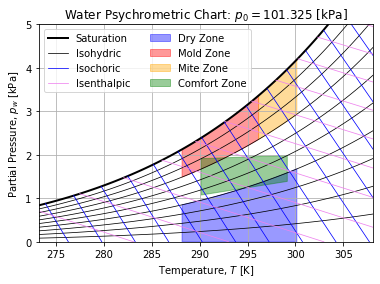

In [27]:
Mix.plot()